### Download and load a previously trained model

Which was saved using:

```python
torch.save(model._neural_diffeq.state_dict(), "scdiffeq_model_checkpoint.pt")
```

In [1]:
import sys
sys.path.insert(0, '/Users/ruitong/scDiffEq')
from scDiffEq_simulation import *

device = "cpu"

rm: /Users/ruitong/.cache/matplotlib: No such file or directory
rm: -rf: No such file or directory
Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [2]:
if not exists("./scdiffeq_model_checkpoint.pt"):   
    ! gsutil -m cp -r gs://ruitong-rotation/scdiffeq_model_checkpoint.pt .

In [3]:
diffeq = neural_diffeq(in_dim=50,
                    out_dim=50,
                    mu={1: [800, 800], 2: [800, 800]},
                    sigma={1: [400, 400], 2: [400, 400]},
                   )
diffeq

NeuralDiffEq(
  (mu): Sequential(
    (input_layer): Linear(in_features=50, out_features=800, bias=True)
    (activation_1): Tanh()
    (dropout_1): Dropout(p=0.5, inplace=False)
    (hidden_1): Linear(in_features=800, out_features=800, bias=True)
    (activation_2): Tanh()
    (dropout_2): Dropout(p=0.5, inplace=False)
    (hidden_2): Linear(in_features=800, out_features=800, bias=True)
    (activation_3): Tanh()
    (dropout_3): Dropout(p=0.5, inplace=False)
    (output_layer): Linear(in_features=800, out_features=50, bias=True)
  )
  (sigma): Sequential(
    (input_layer): Linear(in_features=50, out_features=400, bias=True)
    (activation_1): Tanh()
    (dropout_1): Dropout(p=0.5, inplace=False)
    (hidden_1): Linear(in_features=400, out_features=400, bias=True)
    (activation_2): Tanh()
    (dropout_2): Dropout(p=0.5, inplace=False)
    (hidden_2): Linear(in_features=400, out_features=400, bias=True)
    (activation_3): Tanh()
    (dropout_3): Dropout(p=0.5, inplace=False)
    (

In [4]:
diffeq.load_state_dict(torch.load("scdiffeq_model_checkpoint.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

### Set-up the simulation inputs

In [5]:
if not exists("./Weinreb2020.adata.h5ad"):   
    ! gsutil -m cp -r gs://ruitong-rotation/Weinreb2020.adata.h5ad .

In [5]:
h5adf = "Weinreb2020.adata.h5ad" if not exists("Weinreb2020_newpca.adata.h5ad") else "Weinreb2020_newpca.adata.h5ad"
adata = read_h5ad(h5adf)

In [7]:
if not exists("PCA_WholeLarry_scalar.pickle"):
    annRaw = read_h5ad("../ProcData/Weinreb2020_WholeRaw.adata.h5ad")
    Raw_hvg = annRaw.X[:,annRaw.var.index.isin(adata.var.index)].todense()
    scaler=sklearn.preprocessing.StandardScaler()
    x_ =scaler.fit_transform(Raw_hvg)
    pca = sklearn.decomposition.PCA(n_components = 50)
    adata.obsm['X_pca'] = pca.fit_transform(x_)
    pickle.dump(pca, file = open("PCA_WholeLarry_scalar.pickle", "wb"))
    adata.write("Weinreb2020_newpca.adata.h5ad")

In [8]:
if not exists("UMAP_WholeLarry_PCA.pickle"):
    umap_model = umap.UMAP(n_components=2)
    X_umap = umap_model.fit_transform(adata.obsm['X_pca'])
    pickle.dump(umap_model, file = open("UMAP_WholeLarry_PCA.pickle", "wb"))

In [9]:
# get some early cells
if not exists("toytest_2k.pickle"):
    d2 = adata.obs.loc[adata.obs['Time point'] == 2]
    idx = np.random.choice(d2.index, 2000)

In [9]:
idx = pickle.load(open("toytest_2k.pickle", "rb"))
pca_model = pickle.load(open("PCA_WholeLarry_scalar.pickle", "rb"))
umap_model = pickle.load(open("UMAP_WholeLarry_PCA.pickle", "rb"))

In [11]:
X0 = torch.Tensor(adata[idx].obsm['X_pca']).to(device)
t = torch.Tensor([0, 0.01, 0.02]).to(device)
diffeq = diffeq.to(device)

### Visualize predictions

Build a baseline/reference umap model:

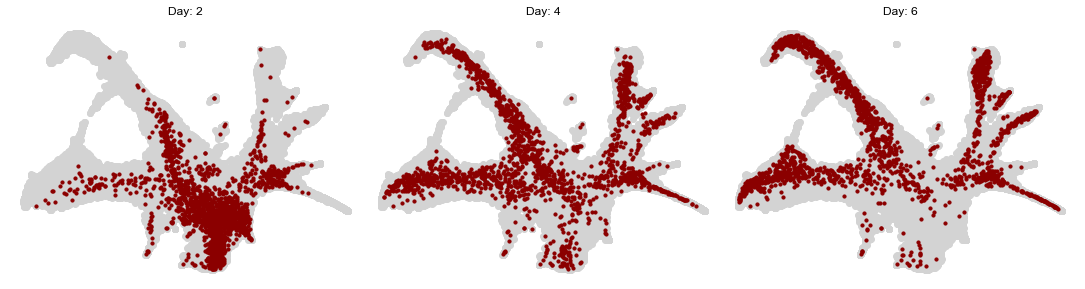

In [12]:
prog_umap(umap_model,adata,idx,diffeq,perturb=False,pcamodel= None,zs=None)

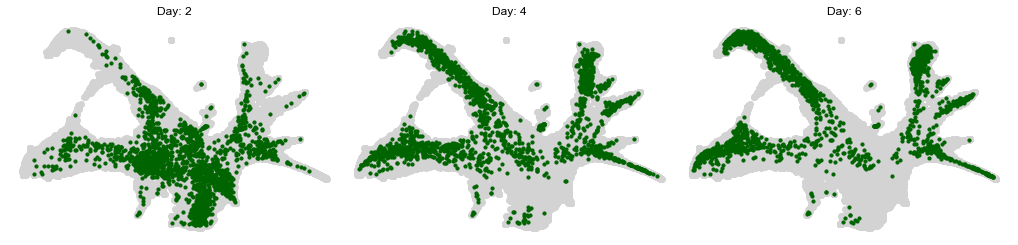

In [13]:
prog_umap(umap_model,adata,idx,diffeq,perturb=True,pcamodel= pca_model,zs=5)

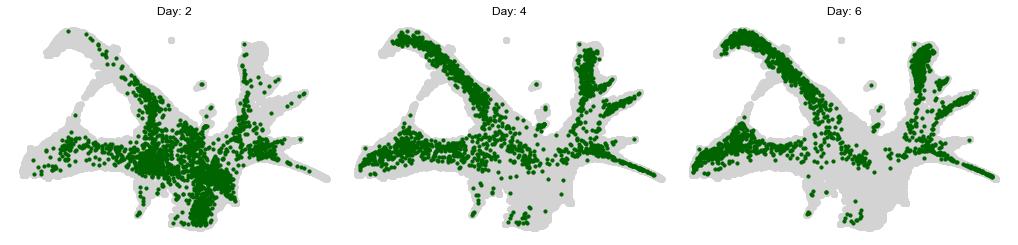

In [14]:
prog_umap(umap_model,adata,idx,diffeq,perturb=True,pcamodel= pca_model,zs=-5)

In [93]:
def sde_simu(adata,idx,pcamodel,zs,diffeq,perturb,device="cpu",ts =[0, 0.01, 0.02]):
    if not perturb:
        startC = adata[idx].obsm['X_pca']
    else:
        startC = zperturb(adata,idx,pcamodel,zs)
    X0 = torch.Tensor(startC).to(device)
    t = torch.Tensor(ts).to(device)
    diffeq = diffeq.to(device)
    with torch.no_grad():
        X_pred = sdeint(diffeq, X0, t)
    X_pred_ = X_pred.detach().cpu().numpy()
    return X_pred_

In [94]:
def NN_Build(adata):
    NN_buildD = adata.obsm['X_pca']
    # Initialize a new index
    # Use HNSW index on Cosine Similarity based on original data
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(NN_buildD)
    index.createIndex({'post': 2}, print_progress=True)
    # Use the annotation for cell type classification
    NN_annotD = adata.obs
    NN_annotD["NewAnnot"] = NN_annotD.Annotation.astype(str)
    NN_annotD.loc[~NN_annotD.Annotation.isin(
    ["undiff", "Neutrophil", "Monocyte"]),"NewAnnot"] = "Others"
    NN_buildDf = pd.DataFrame(NN_buildD,NN_annotD.NewAnnot)
    return index,NN_buildD,NN_annotD,NN_buildDf

In [95]:
def NN_Classify(index,NN_buildDf,NN_findD,n_neighbor):
    CountList = []
    for snap in NN_findD: 
        # Batch query nearest neighbours for simulated data at each tp
        neighbours = index.knnQueryBatch(snap,k=n_neighbor,num_threads=4)
        LabelCount = [Counter(NN_buildDf.iloc[i].index).most_common(2)[0][0] for i in neighbours]
        CountList.append(Counter(LabelCount))
    return CountList

In [96]:
def CellType_Stack(countl):
    plt.figure(figsize=(8,8))
    sns.set_context("talk")
    labels=["undiff", "Neutrophil", "Monocyte", "Others"]
    colors=["darkgrey", "orange", "green", "crimson"]
    udC,NC,MonoC,OthrC = [list(map(itemgetter(l), countl)) for l in labels]
    plt.stackplot(np.arange(len(udC)),
                  udC,NC,MonoC,OthrC,
                  labels=labels, colors=colors)
    plt.legend(loc='lower left', prop={'size': 14})
    plt.margins(0,0)
    plt.title('Unperturbed cells')
    plt.xlabel(f"Time from day 2 to 6 (Steps = {len(countl)})")
    plt.ylabel("Count of cell type")
    plt.show()

In [97]:
def continum_celltype(adata,idx,diffeq,steps = 20,perturb=False,pcamodel= None,zs=None,nn=10):
    NN_findD = sde_simu(adata,idx,pcamodel,zs,diffeq,perturb,
                        ts = np.linspace(0,0.02,steps))
    indexNN,_,_,NN_buildDf = NN_Build(adata)
    classedCT = NN_Classify(indexNN,NN_buildDf,NN_findD,nn)
    CellType_Stack(classedCT)
    return classedCT

In [91]:
perturb=False
pcamodel= None
zs=None
nn=10


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
*


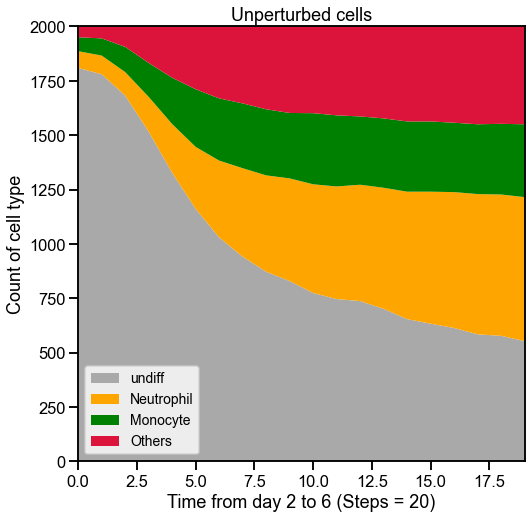

In [98]:
_ = continum_celltype(adata,idx,diffeq)

In [20]:
startC = adata[idx].obsm['X_pca']
X0 = torch.Tensor(startC).to(device)
t = torch.Tensor(np.linspace(0,0.02,20)).to(device)
diffeq = diffeq.to(device)
with torch.no_grad():
    X_pred = sdeint(diffeq, X0, t)
X_pred_ = X_pred.detach().cpu().numpy()

Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [21]:
NN_buildD = adata.obsm['X_pca']
NN_findD =  X_pred_

In [32]:
NN_annotD = adata.obs
NN_annotD["NewAnnot"] = NN_annotD.Annotation.astype(str)
NN_annotD.loc[~NN_annotD.Annotation.isin(
    ["undiff", "Neutrophil", "Monocyte"]),"NewAnnot"] = "Others"

In [36]:
NN_buildDf = pd.DataFrame(NN_buildD,NN_annotD.NewAnnot)

In [22]:
# Initialize a new index
# Use HNSW index on Cosine Similarity based on original data
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(NN_buildD)
index.createIndex({'post': 2}, print_progress=True)


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

In [17]:
device = "cpu"
perturb = False
X_umap = umap_model.transform(adata.obsm['X_pca'])
if not perturb:
    startC = adata[idx].obsm['X_pca']
else:
    startC = zperturb(adata,idx,pcamodel,zs)
X0 = torch.Tensor(startC).to(device)
t = torch.Tensor([0, 0.01, 0.02]).to(device)
diffeq = diffeq.to(device)
with torch.no_grad():
    X_pred = sdeint(diffeq, X0, t)
X_pred_ = X_pred.detach().cpu().numpy()

Multiple header file got deprecated/messed up in newer mac os systems.

I have tried multiple methods:
+ Reomve and reinstall xcode-select (almost 30mins)
+ Try add symbolic link to /usr/include since that permanently got removed by mac
+ Add xcrun path to .bash_profile and also .zshrc
+ The original error of not locating stdio.h resolved with new errors
+ Ultimately, I think there are some incompatibilty of header location in the new mac sys


Decided to change to another method for finding approximate nearest neighbors.

Annoy's author [benchmarked](https://erikbern.com/2018/06/17/new-approximate-nearest-neighbor-benchmarks.html) multiple methods and sugggested to use [hnsw(nmbslib)](https://nmslib.github.io/nmslib/quickstart.html#installation) for approximate nearst neighbors.

In [1]:
# Annoy's author blogged on benchmarking 
import nmslib
import numpy

# create a random matrix to index
data = numpy.random.randn(10000, 100).astype(numpy.float32)

# initialize a new index, using a HNSW index on Cosine Similarity based on original data
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

# get all nearest neighbours for simulated data
neighbours = index.knnQueryBatch(data, k=n, num_threads=4)

Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

In [11]:
ann = adata
x = ann[idx].X
scaler=sklearn.preprocessing.StandardScaler()
x_ =scaler.fit_transform(x.toarray())
PGenes=perturb_genes.split(";")
perturb_genes="Klf4;Nr4a1"
PGenes=perturb_genes.split(";")
x_[:,ann.var.gene_id.isin(PGenes)] = 5
xp = pca.transform(x_)
#x_[:,ann.var.gene_id.isin(PGenes)] = zs

In [16]:
x_[:,ann.var.gene_id.isin(PGenes)]

(2000, 2)

In [18]:
zs = 5
pg = "Klf4;Nr4a1"

In [21]:
perturb_genes="Klf4"
PGenes=perturb_genes.split(";")

In [22]:
PGenes

['Klf4']

In [7]:
adata.var.gene_id.isin(PGenes).value_counts()

False    2445
True        2
Name: gene_id, dtype: int64

In [19]:
message="Running perturbations of " + pg + " " + "w/ z-score of " + str(zs)

In [20]:
print(message)

Running perturbations of Klf4;Nr4a1 w/ z-score of 5
